<a href="https://colab.research.google.com/github/carolshayle/Python/blob/main/Google_Maps_Jimaacale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Install necessary libraries
# Geopandas is used for handling geographic data (the city boundary)
# Folium is used for creating interactive maps
!pip install geopandas folium -q

In [1]:
import geopandas as gpd
import requests
from PIL import Image
from io import BytesIO
import folium
import zipfile
import os
import math
from google.colab import files
from google.colab import userdata
import matplotlib.pyplot as plt # Added for displaying multiple images

In [2]:
try:
    API_KEY = userdata.get('GOOGLE_MAPS_API_KEY')
    print("✅ Successfully loaded API Key from Colab secrets.")
except userdata.SecretNotFoundError:
    print("🛑 ERROR: API Key not found. Please follow the instructions to add it to Colab secrets.")
    API_KEY = "YOUR_API_KEY_HERE" # Fallback, but not recommended
except Exception as e:
    print(f"An error occurred: {e}")

✅ Successfully loaded API Key from Colab secrets.


In [3]:
# Cell 2 (Final Version): Upload, Process, and Get Correct Coordinates
print("--- Step 1: Uploading and Processing Your Local Shapefile ---")

try:
    # --- Part A: Upload the ZIP file ---
    print("Please select the ZIP file containing your shapefile...")
    uploaded = files.upload()

    if not uploaded:
        raise Exception("No file was uploaded. Please run the cell again.")

    zip_file_name = list(uploaded.keys())[0]
    print(f"\n✅ Successfully uploaded '{zip_file_name}'")

    # --- Part B: Unzip the file ---
    shapefile_dir = "/content/mogadishu_shapefile/"
    if os.path.exists(shapefile_dir):
        import shutil
        shutil.rmtree(shapefile_dir)
    os.makedirs(shapefile_dir)

    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        zip_ref.extractall(shapefile_dir)
    print(f"✅ Files extracted to '{shapefile_dir}'")

    # --- Part C: Find and load the .shp file ---
    shp_file_path = None
    for root, dirs, files_in_dir in os.walk(shapefile_dir):
        for file in files_in_dir:
            if file.endswith(".shp"):
                shp_file_path = os.path.join(root, file)
                break
        if shp_file_path:
            break

    if not shp_file_path:
        raise Exception("Could not find a .shp file in the uploaded zip archive.")

    mogadishu_gdf_original = gpd.read_file(shp_file_path)
    print("\n✅ Shapefile loaded successfully.")

    # --- Part D: Calculate Area (using a projected system for accuracy) ---
    # Project to a local UTM zone (EPSG:32638 for Mogadishu) for accurate area calculation.
    mogadishu_utm = mogadishu_gdf_original.to_crs(epsg=32638)
    area_sq_meters = mogadishu_utm.geometry.area.sum()
    area_sq_km = area_sq_meters / 1_000_000
    print(f"✅ Calculated Area of Mogadishu: {area_sq_km:.2f} sq km")

    # --- Part E: Calculate Center Point (using WGS84 Lat/Lon for API) ---
    # **THIS IS THE CRITICAL FIX**
    # We ensure the GeoDataFrame is in the standard WGS84 (EPSG:4326) format.
    mogadishu_wgs84 = mogadishu_gdf_original.to_crs(epsg=4326)

    # Calculate the centroid from the correctly projected data
    # Also, updated to use the recommended 'union_all()' method
    center_point = mogadishu_wgs84.geometry.union_all().centroid
    center_lat = center_point.y
    center_lon = center_point.x

    print(f"✅ Center coordinates (Lat, Lon): {center_lat:.4f}, {center_lon:.4f}")

except Exception as e:
    print(f"\n🛑 AN ERROR OCCURRED: {e}")
    print("\nPlease check that you uploaded a valid ZIP file and try running the cell again.")

--- Step 1: Uploading and Processing Your Local Shapefile ---
Please select the ZIP file containing your shapefile...


Saving Mogadishu.zip to Mogadishu.zip

✅ Successfully uploaded 'Mogadishu.zip'
✅ Files extracted to '/content/mogadishu_shapefile/'

✅ Shapefile loaded successfully.
✅ Calculated Area of Mogadishu: 494.74 sq km
✅ Center coordinates (Lat, Lon): 2.0963, 45.3266


In [4]:
# Cell 3: Visualize the boundary
print("\n--- Step 2: Visualizing the Boundary on an Interactive Map ---")

# Create a map centered on Mogadishu
m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# Add the Mogadishu boundary to the map
folium.GeoJson(
    mogadishu_wgs84,
    style_function=lambda feature: {
        'fillColor': 'blue',
        'color': 'black',
        'weight': 2,
        'fillOpacity': 0.2,
    }
).add_to(m)

# Add a marker at the center
folium.Marker(
    [center_lat, center_lon],
    popup=f"Mogadishu Center\nArea: {area_sq_km:.2f} sq km"
).add_to(m)

# Display the map
display(m)


--- Step 2: Visualizing the Boundary on an Interactive Map ---


In [5]:
# Cell 4: Calculate imagery costs
print("\n--- Step 3: Calculating Cost of Imagery ---")

# --- Cost Model 1: A Single Overview Image (like the one we will get) ---
# The Maps Static API is priced per 1000 requests.
# As of late 2023, the price is ~$2.00 per 1000 requests.
cost_per_1000_requests = 2.00
cost_per_single_request = cost_per_1000_requests / 1000

print(f"Cost for a single API call (one overview image): ${cost_per_single_request:.4f}")
print("Google provides a $200 free monthly credit, so this single call will be free.")

# --- Cost Model 2: Hypothetical Tiling for Full Coverage ---
# This is a rough estimate to illustrate the concept.
# A single 640x640 image can't cover a whole city at high detail.
# To get high-resolution imagery for the whole area, you would need to "tile" many images.
# NOTE: Bulk downloading via the Static API is against Google's ToS. This is for educational purposes.

# Assumptions:
zoom_level_tiling = 19
scale = 2  # A reasonably high zoom level for detail
tile_size_pixels = 640 # Standard tile size for the API

# Estimate the ground area covered by a single tile at this zoom level near the equator.
# Formula: meters_per_pixel = 156543.03 * cos(latitude) / (2^zoom_level)
# Using center_lat for a more accurate local estimate
meters_per_pixel = 156543.03 * abs(math.cos(math.radians(center_lat))) / (2**zoom_level_tiling)
tile_width_meters = tile_size_pixels * meters_per_pixel
tile_area_sq_km = (tile_width_meters ** 2) / 1_000_000

# Calculate how many tiles are needed to cover the entire city area
# We add a 10% buffer for overlap
num_tiles_needed = (area_sq_km / tile_area_sq_km) * 1.10

print(f"\n--- Hypothetical High-Res Tiling Calculation (for educational purposes) ---")
print(f"Desired Zoom Level: {zoom_level_tiling}")
print(f"Estimated area covered by one {tile_size_pixels}x{tile_size_pixels} tile: {tile_area_sq_km:.4f} sq km")
print(f"Estimated number of tiles needed to cover {area_sq_km:.2f} sq km: {int(num_tiles_needed)}")

# Calculate the hypothetical cost
hypothetical_cost = (num_tiles_needed / 1000) * cost_per_1000_requests
print(f"Hypothetical cost to tile the entire city at zoom {zoom_level_tiling}: ${hypothetical_cost:.2f}")
print("NOTE: For actual high-resolution satellite imagery, you would purchase it from a commercial provider like Maxar or Planet Labs, which would have a different (and likely higher) cost structure.")


--- Step 3: Calculating Cost of Imagery ---
Cost for a single API call (one overview image): $0.0020
Google provides a $200 free monthly credit, so this single call will be free.

--- Hypothetical High-Res Tiling Calculation (for educational purposes) ---
Desired Zoom Level: 19
Estimated area covered by one 640x640 tile: 0.0365 sq km
Estimated number of tiles needed to cover 494.74 sq km: 14923
Hypothetical cost to tile the entire city at zoom 19: $29.85
NOTE: For actual high-resolution satellite imagery, you would purchase it from a commercial provider like Maxar or Planet Labs, which would have a different (and likely higher) cost structure.



--- Step 4: Fetching the Google Static Map Image ---
✅ Successfully fetched the image from Google Maps API.


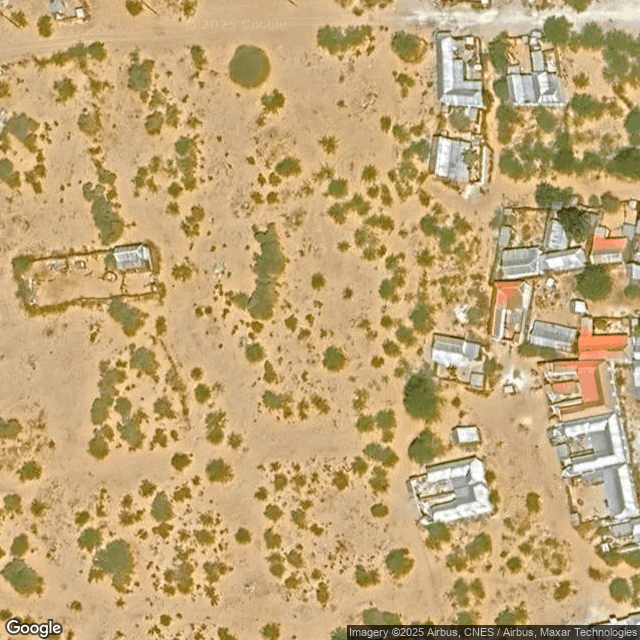

In [6]:
# Cell 5: Fetch the Google Static Map Image
print("\n--- Step 4: Fetching the Google Static Map Image ---")

# Define the parameters for the Static Map API request
base_url = "https://maps.googleapis.com/maps/api/staticmap?"
params = {
    "center": f"{center_lat},{center_lon}",
    "zoom": 19,  # A good zoom level to see the whole city area
    "size": "640x640",
    "maptype": "satellite",
    "key": API_KEY
}

# Make the request to the API
response = requests.get(base_url, params=params)

# Check if the request was successful
if response.status_code == 200:
    print("✅ Successfully fetched the image from Google Maps API.")
    # Open the image from the response content
    map_image = Image.open(BytesIO(response.content))
    # Display the image
    display(map_image)
else:
    print(f"🛑 ERROR: Failed to get image. Status Code: {response.status_code}")
    print(f"Response Text: {response.text}")
    print("\nCommon reasons for failure:")
    print("- API Key is invalid or has not been activated.")
    print("- 'Maps Static API' is not enabled in your Google Cloud project.")
    print("- Billing is not enabled for your project.")
    print("- You have exceeded your daily quota.")


--- NEW Step 5: Visualizing Multiple Map Tiles ---
This demonstrates how multiple smaller images can cover a larger area with more detail.

✅ Attempted to fetch 6 tiles.


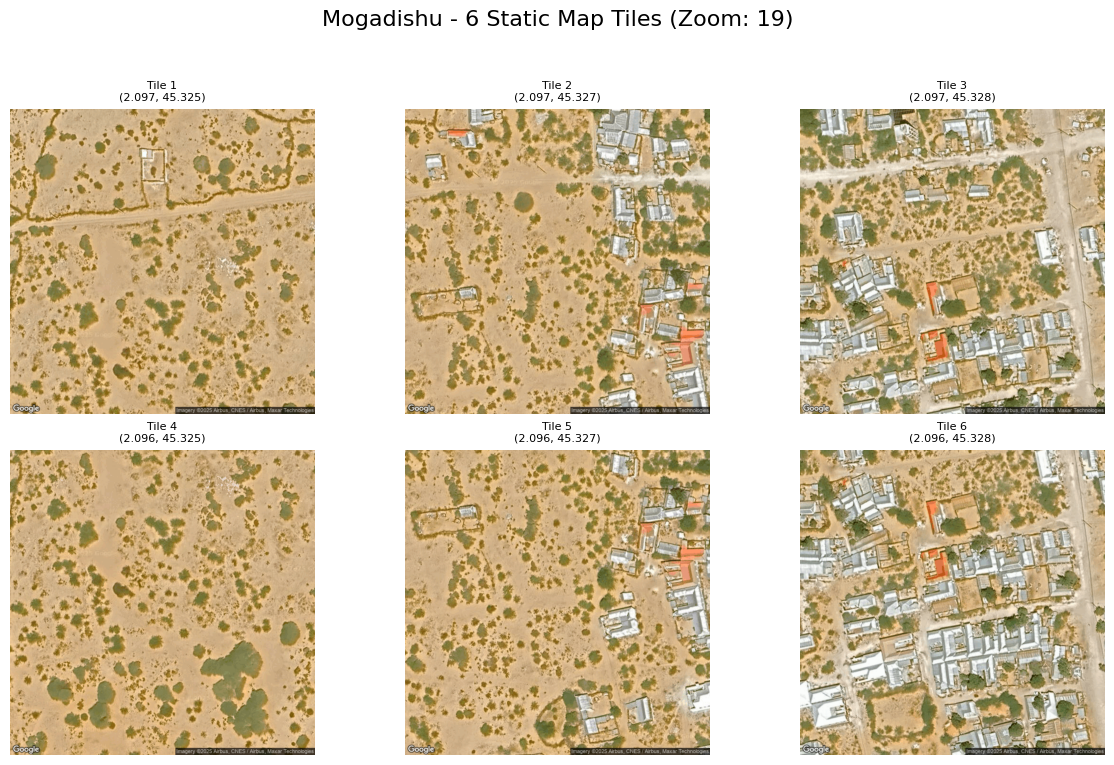

In [7]:
# Cell 6: Visualize at least 6 tiles in a grid
print("\n--- NEW Step 5: Visualizing Multiple Map Tiles ---")
print("This demonstrates how multiple smaller images can cover a larger area with more detail.")

# Parameters for our tiles
tile_zoom = 19       # Higher zoom for more detail per tile
tile_size = 640      # Pixels for width/height of each tile
rows = 2
cols = 3
num_tiles = rows * cols

# Calculate approximate degree step for a 640x640 tile at this zoom/latitude
# (Simplified Mercator projection calculation for approximation)
# Reference: https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames
# The Earth's circumference at the equator is approx 40075 km.
# At zoom 0, 1 tile (256x256) covers 360 degrees.
# A 640x640 tile is 640/256 = 2.5 times a standard tile.

# Approximate degrees per pixel at equator for Mercator, then adjust for latitude
# Meters per pixel at equator at zoom level Z = 156543.03 / (2^Z)
# Degrees per pixel longitude = (360 / (2^Z * 256))
# Degrees per pixel latitude (approx) = (180 / (2^Z * 256)) # This is rough, latitude changes

# Let's derive a more stable degree offset.
# For a 640x640 tile at zoom 'tile_zoom':
# The total width/height in 'standard' 256x256 tiles is `tile_size / 256 = 2.5`
# The angular width of a standard tile at zoom `tile_zoom` is `360 / (2**tile_zoom)` degrees longitude
# So, the approximate angular width for our 640x640 tile is `2.5 * 360 / (2**tile_zoom)` degrees longitude.
# This assumes it's at the equator. We'll use this for horizontal spacing.

# For vertical spacing, it's more complex but we can use a similar ratio or a slightly smaller factor.
# Let's use an approximate factor based on the tile_size/256 for both.
degree_width_per_standard_tile = 360 / (2**tile_zoom)
degree_height_per_standard_tile = 180 / (2**tile_zoom) # Very rough for latitude

lon_step = (tile_size / 256) * degree_width_per_standard_tile
lat_step = (tile_size / 256) * degree_height_per_standard_tile * 0.8 # Slightly smaller step for lat for better overlap

# Prepare a list to store image data
tile_images = []
tile_centers = []

# Calculate start coordinates for the top-left tile to form a grid centered around center_lat, center_lon
start_lat = center_lat + lat_step * (rows - 1) / 2
start_lon = center_lon - lon_step * (cols - 1) / 2

current_lat = start_lat
for r in range(rows):
    current_lon = start_lon
    for c in range(cols):
        tile_centers.append((current_lat, current_lon))

        params = {
            "center": f"{current_lat},{current_lon}",
            "zoom": tile_zoom,
            "size": f"{tile_size}x{tile_size}",
            "maptype": "satellite",
            "key": API_KEY
        }

        try:
            response = requests.get(base_url, params=params)
            if response.status_code == 200:
                tile_images.append(Image.open(BytesIO(response.content)))
            else:
                print(f"🛑 Error fetching tile for ({current_lat:.4f}, {current_lon:.4f}): {response.status_code} - {response.text}")
                tile_images.append(None) # Add None to maintain grid structure
        except Exception as e:
            print(f"🛑 Exception fetching tile for ({current_lat:.4f}, {current_lon:.4f}): {e}")
            tile_images.append(None)

        current_lon += lon_step
    current_lat -= lat_step # Move south for next row

print(f"\n✅ Attempted to fetch {num_tiles} tiles.")

# Display the tiles in a grid
if any(tile_images): # Only display if at least one image was successfully fetched
    plt.figure(figsize=(cols * 4, rows * 4)) # Adjust figure size based on grid
    for i, img in enumerate(tile_images):
        plt.subplot(rows, cols, i + 1)
        if img:
            plt.imshow(img)
            plt.title(f"Tile {i+1}\n({tile_centers[i][0]:.3f}, {tile_centers[i][1]:.3f})", fontsize=8)
        else:
            plt.text(0.5, 0.5, 'Image Failed', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12, color='red')
            plt.axis('off') # Hide axes for failed image slots
        plt.axis('off') # Hide axes for all images

    plt.suptitle(f"Mogadishu - {num_tiles} Static Map Tiles (Zoom: {tile_zoom})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()
else:
    print("🛑 No tiles could be fetched. Please check your API key and network connection.")


In [8]:
# Cell 2 (Final Version): Upload, Process, and Get Correct Coordinates
print("--- Step 1: Uploading and Processing Your Local Shapefile ---")

try:
    # --- Part A: Upload the ZIP file ---
    print("Please select the ZIP file containing your shapefile...")
    uploaded = files.upload()

    if not uploaded:
        raise Exception("No file was uploaded. Please run the cell again.")

    zip_file_name = list(uploaded.keys())[0]
    print(f"\n✅ Successfully uploaded '{zip_file_name}'")

    # --- Part B: Unzip the file ---
    shapefile_dir = "/content/yaaqshid_shapefile/"
    if os.path.exists(shapefile_dir):
        import shutil
        shutil.rmtree(shapefile_dir)
    os.makedirs(shapefile_dir)

    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        zip_ref.extractall(shapefile_dir)
    print(f"✅ Files extracted to '{shapefile_dir}'")

    # --- Part C: Find and load the .shp file ---
    shp_file_path = None
    for root, dirs, files_in_dir in os.walk(shapefile_dir):
        for file in files_in_dir:
            if file.endswith(".shp"):
                shp_file_path = os.path.join(root, file)
                break
        if shp_file_path:
            break

    if not shp_file_path:
        raise Exception("Could not find a .shp file in the uploaded zip archive.")

    yaaqshid_gdf_original = gpd.read_file(shp_file_path)
    print("\n✅ Shapefile loaded successfully.")

    # --- Part D: Calculate Area (using a projected system for accuracy) ---
    # Project to a local UTM zone (EPSG:32638 for Mogadishu) for accurate area calculation.
    yaaqshid_utm = yaaqshid_gdf_original.to_crs(epsg=32638)
    area_sq_meters = yaaqshid_utm.geometry.area.sum()
    area_sq_km = area_sq_meters / 1_000_000
    print(f"✅ Calculated Area of yaaqshid: {area_sq_km:.2f} sq km")

    # --- Part E: Calculate Center Point (using WGS84 Lat/Lon for API) ---
    # **THIS IS THE CRITICAL FIX**
    # We ensure the GeoDataFrame is in the standard WGS84 (EPSG:4326) format.
    yaaqshid_wgs84 = yaaqshid_gdf_original.to_crs(epsg=4326)

    # Calculate the centroid from the correctly projected data
    # Also, updated to use the recommended 'union_all()' method
    center_point = yaaqshid_wgs84.geometry.union_all().centroid
    center_lat = center_point.y
    center_lon = center_point.x

    print(f"✅ Center coordinates (Lat, Lon): {center_lat:.4f}, {center_lon:.4f}")

except Exception as e:
    print(f"\n🛑 AN ERROR OCCURRED: {e}")
    print("\nPlease check that you uploaded a valid ZIP file and try running the cell again.")

--- Step 1: Uploading and Processing Your Local Shapefile ---
Please select the ZIP file containing your shapefile...


Saving CLIP.zip to CLIP.zip

✅ Successfully uploaded 'CLIP.zip'
✅ Files extracted to '/content/yaaqshid_shapefile/'

✅ Shapefile loaded successfully.
✅ Calculated Area of yaaqshid: 0.10 sq km
✅ Center coordinates (Lat, Lon): 2.0522, 45.3377


In [9]:
# Cell 1: Calculate Extent and Plan the Tiling Grid

import math
import time
from IPython.display import display, clear_output

# --- KEY PARAMETERS TO SET ---
ZOOM_LEVEL = 19  # Higher number = more detail, more tiles. 17 or 18 is good for urban areas.
TILE_SIZE = 640  # Standard Google Static Map API tile size in pixels
# -----------------------------

# Ensure the GeoDataFrame is in the correct coordinate system (WGS84)
yaaqshid_gdf_wgs84 = yaaqshid_gdf_original.to_crs(epsg=4326)

# 1. Calculate the bounding box of your shapefile
bounds = yaaqshid_gdf_wgs84.total_bounds
min_lon, min_lat, max_lon, max_lat = bounds
center_lat_for_calc = (min_lat + max_lat) / 2
print(f"Area Bounding Box (Lat/Lon):")
print(f"  Min: ({min_lat:.4f}, {min_lon:.4f})")
print(f"  Max: ({max_lat:.4f}, {max_lon:.4f})")

# 2. Calculate the geographic size (in degrees) of a single tile at this zoom and latitude
# The longitude span of a tile is constant, but latitude span changes.
# Formula ref: https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames
# For a 640px tile, it's 2.5 times the size of a standard 256px tile.
lon_deg_per_tile = (TILE_SIZE / 256) * (360 / (2**ZOOM_LEVEL))
lat_deg_per_tile = lon_deg_per_tile * math.cos(math.radians(center_lat_for_calc))

print(f"\nAt Zoom {ZOOM_LEVEL}, one {TILE_SIZE}px tile covers approx:")
print(f"  {lon_deg_per_tile:.5f} degrees of longitude")
print(f"  {lat_deg_per_tile:.5f} degrees of latitude")

# 3. Determine how many rows and columns of tiles are needed to cover the area
lon_span = max_lon - min_lon
lat_span = max_lat - min_lat
num_cols = math.ceil(lon_span / lon_deg_per_tile)
num_rows = math.ceil(lat_span / lat_deg_per_tile)
total_tiles = num_rows * num_cols

print(f"\nGrid calculation:")
print(f"  Columns needed: {num_cols}")
print(f"  Rows needed: {num_rows}")
print(f"  Total tiles to fetch: {total_tiles}")

# --- SAFETY WARNING AND CONFIRMATION ---
cost_per_1000 = 2.00 # $2.00 per 1000 requests (Static Maps SKU)
estimated_cost = (total_tiles / 1000) * cost_per_1000

print("\n" + "="*50)
print("⚠️  WARNING: API USAGE AND COST ESTIMATE  ⚠️")
print("="*50)
print(f"This operation will make {total_tiles} separate calls to the Google Maps API.")
print(f"Estimated cost: ${estimated_cost:.2f} (This will likely be covered by your $200 free monthly credit).")
print("Google's Terms of Service discourage bulk downloading. This is for educational/small-scale use.")
print("="*50)

# User confirmation to proceed
# To run automatically without asking, comment out the next 3 lines
# proceed = input("Do you want to proceed with fetching the images? (yes/no): ")
# if proceed.lower() != 'yes':
#     raise Exception("Operation cancelled by user.")

# If you are sure, you can uncomment the line below and comment out the input lines above.
print("\nProceeding with image fetching...")

Area Bounding Box (Lat/Lon):
  Min: (2.0509, 45.3357)
  Max: (2.0537, 45.3397)

At Zoom 19, one 640px tile covers approx:
  0.00172 degrees of longitude
  0.00172 degrees of latitude

Grid calculation:
  Columns needed: 3
  Rows needed: 2
  Total tiles to fetch: 6

⚠️  WARNING: API USAGE AND COST ESTIMATE  ⚠️
This operation will make 6 separate calls to the Google Maps API.
Estimated cost: $0.01 (This will likely be covered by your $200 free monthly credit).
Google's Terms of Service discourage bulk downloading. This is for educational/small-scale use.

Proceeding with image fetching...


In [10]:
# Cell 2: Loop Through the Grid and Fetch All Tiles

base_url = "https://maps.googleapis.com/maps/api/staticmap?"
tile_images = []
failed_tiles = 0

# Start at the top-left corner of the bounding box
start_lat = max_lat
start_lon = min_lon

print(f"Fetching {total_tiles} tiles. This may take a moment...")

for r in range(num_rows):
    for c in range(num_cols):
        # Calculate the center of the current tile
        # We add half a tile's dimension to the corner to get to the center
        tile_center_lon = start_lon + (c + 0.5) * lon_deg_per_tile
        tile_center_lat = start_lat - (r + 0.5) * lat_deg_per_tile

        current_tile_num = (r * num_cols) + c + 1
        print(f"  Fetching tile {current_tile_num}/{total_tiles}...")

        params = {
            "center": f"{tile_center_lat},{tile_center_lon}",
            "zoom": ZOOM_LEVEL,
            "size": f"{TILE_SIZE}x{TILE_SIZE}",
            "maptype": "satellite",
            "key": API_KEY
        }

        try:
            response = requests.get(base_url, params=params)
            if response.status_code == 200:
                tile_images.append(Image.open(BytesIO(response.content)))
            else:
                print(f"    -> ERROR fetching tile {current_tile_num}. Status: {response.status_code}")
                tile_images.append(None) # Add a placeholder for failed tiles
                failed_tiles += 1
        except Exception as e:
            print(f"    -> EXCEPTION on tile {current_tile_num}: {e}")
            tile_images.append(None)
            failed_tiles += 1

        clear_output(wait=True) # Clears the output to show only the latest status

print("--- Download Complete ---")
print(f"Successfully fetched: {total_tiles - failed_tiles} tiles")
print(f"Failed to fetch: {failed_tiles} tiles")

--- Download Complete ---
Successfully fetched: 6 tiles
Failed to fetch: 0 tiles



Stitching tiles into a single mosaic image...
✅ Mosaic created successfully!


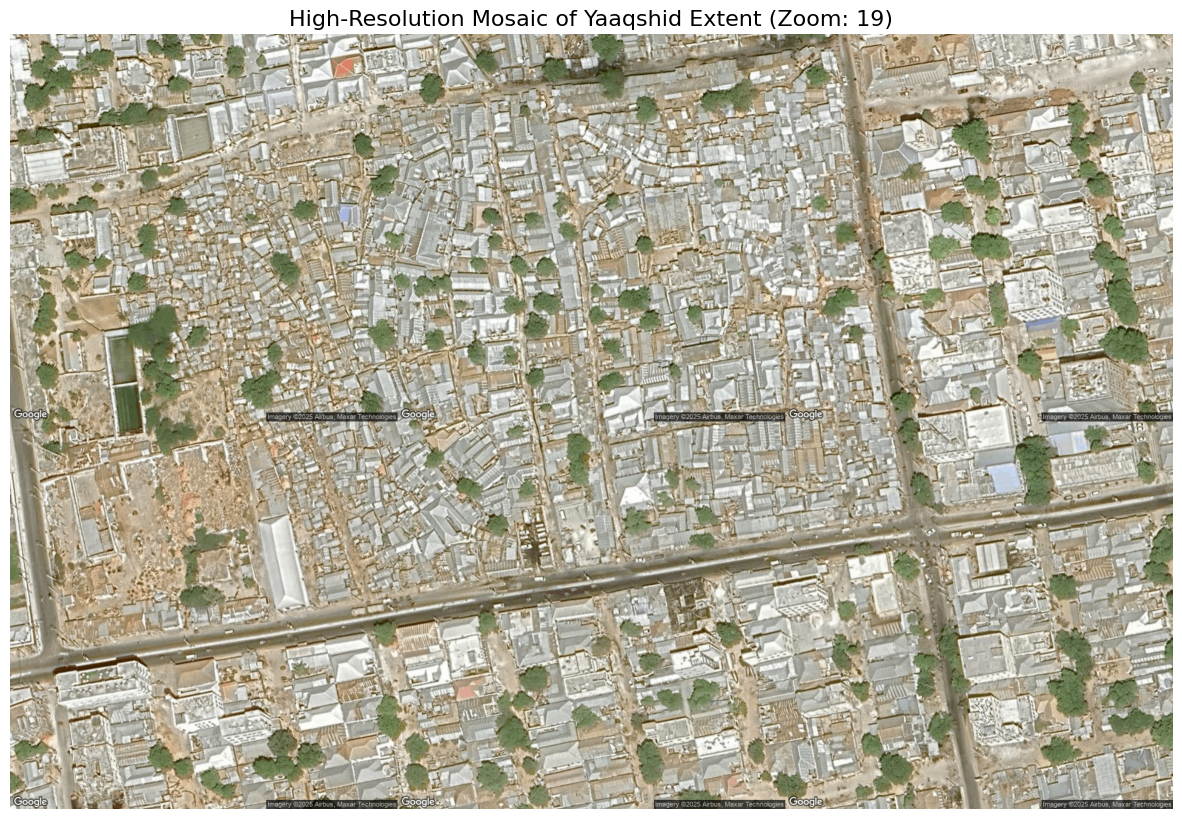


Image saved to: /content/yaaqshid_mosaic_zoom_19.png
You can find it in the file browser on the left sidebar.


In [11]:
# Cell 3: Stitch Tiles into a Mosaic and Display

if not any(tile_images):
    print("\n🛑 No images were downloaded. Cannot create a mosaic.")
else:
    print("\nStitching tiles into a single mosaic image...")

    # Create a new, blank image to paste the tiles onto
    total_width = num_cols * TILE_SIZE
    total_height = num_rows * TILE_SIZE
    mosaic_image = Image.new('RGB', (total_width, total_height))

    # Paste each tile into its correct position
    for i, img in enumerate(tile_images):
        if img:
            row = i // num_cols
            col = i % num_cols
            x_offset = col * TILE_SIZE
            y_offset = row * TILE_SIZE
            mosaic_image.paste(img, (x_offset, y_offset))
        else:
            # Optionally, you could draw a "failed" box here
            pass

    print("✅ Mosaic created successfully!")

    # Display the final stitched image
    # We use matplotlib to control the size of the output display
    plt.figure(figsize=(15, 15)) # Adjust figure size for better viewing
    plt.imshow(mosaic_image)
    plt.title(f"High-Resolution Mosaic of Yaaqshid Extent (Zoom: {ZOOM_LEVEL})", fontsize=16)
    plt.axis('off') # Hide the black axes and ticks
    plt.show()

    # Optional: Save the final image to your Colab environment
    try:
        save_path = f"/content/yaaqshid_mosaic_zoom_{ZOOM_LEVEL}.png"
        mosaic_image.save(save_path)
        print(f"\nImage saved to: {save_path}")
        print("You can find it in the file browser on the left sidebar.")
    except Exception as e:
        print(f"\nCould not save the image. Error: {e}")

In [17]:
# Cell 2 (Final Version): Upload, Process, and Get Correct Coordinates
print("--- Step 1: Uploading and Processing Your Local Shapefile ---")

try:
    # --- Part A: Upload the ZIP file ---
    print("Please select the ZIP file containing your shapefile...")
    uploaded = files.upload()

    if not uploaded:
        raise Exception("No file was uploaded. Please run the cell again.")

    zip_file_name = list(uploaded.keys())[0]
    print(f"\n✅ Successfully uploaded '{zip_file_name}'")

    # --- Part B: Unzip the file ---
    shapefile_dir = "/content/jimaacale_shapefile/"
    if os.path.exists(shapefile_dir):
        import shutil
        shutil.rmtree(shapefile_dir)
    os.makedirs(shapefile_dir)

    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        zip_ref.extractall(shapefile_dir)
    print(f"✅ Files extracted to '{shapefile_dir}'")

    # --- Part C: Find and load the .shp file ---
    shp_file_path = None
    for root, dirs, files_in_dir in os.walk(shapefile_dir):
        for file in files_in_dir:
            if file.endswith(".shp"):
                shp_file_path = os.path.join(root, file)
                break
        if shp_file_path:
            break

    if not shp_file_path:
        raise Exception("Could not find a .shp file in the uploaded zip archive.")

    jimaacale_gdf_original = gpd.read_file(shp_file_path)
    print("\n✅ Shapefile loaded successfully.")

    # --- Part D: Calculate Area (using a projected system for accuracy) ---
    # Project to a local UTM zone (EPSG:32638 for Mogadishu) for accurate area calculation.
    jimaacale_utm = jimaacale_gdf_original.to_crs(epsg=32638)
    area_sq_meters = jimaacale_utm.geometry.area.sum()
    area_sq_km = area_sq_meters / 1_000_000
    print(f"✅ Calculated Area of jimaacale: {area_sq_km:.2f} sq km")

    # --- Part E: Calculate Center Point (using WGS84 Lat/Lon for API) ---
    # **THIS IS THE CRITICAL FIX**
    # We ensure the GeoDataFrame is in the standard WGS84 (EPSG:4326) format.
    jimaacale_wgs84 = jimaacale_gdf_original.to_crs(epsg=4326)

    # Calculate the centroid from the correctly projected data
    # Also, updated to use the recommended 'union_all()' method
    center_point = jimaacale_wgs84.geometry.union_all().centroid
    center_lat = center_point.y
    center_lon = center_point.x

    print(f"✅ Center coordinates (Lat, Lon): {center_lat:.4f}, {center_lon:.4f}")

except Exception as e:
    print(f"\n🛑 AN ERROR OCCURRED: {e}")
    print("\nPlease check that you uploaded a valid ZIP file and try running the cell again.")

--- Step 1: Uploading and Processing Your Local Shapefile ---
Please select the ZIP file containing your shapefile...


Saving Jimaacali.zip to Jimaacali (2).zip

✅ Successfully uploaded 'Jimaacali (2).zip'
✅ Files extracted to '/content/jimaacale_shapefile/'

✅ Shapefile loaded successfully.
✅ Calculated Area of jimaacale: 0.24 sq km
✅ Center coordinates (Lat, Lon): 2.0237, 45.3079


In [18]:
# Cell 1: Calculate Extent and Plan the Tiling Grid

import math
import time
from IPython.display import display, clear_output

# --- KEY PARAMETERS TO SET ---
ZOOM_LEVEL = 19  # Higher number = more detail, more tiles. 17 or 18 is good for urban areas.
TILE_SIZE = 640  # Standard Google Static Map API tile size in pixels
# -----------------------------

# Ensure the GeoDataFrame is in the correct coordinate system (WGS84)
jimaacale_gdf_wgs84 = jimaacale_gdf_original.to_crs(epsg=4326)

# 1. Calculate the bounding box of your shapefile
bounds = jimaacale_gdf_wgs84.total_bounds
min_lon, min_lat, max_lon, max_lat = bounds
center_lat_for_calc = (min_lat + max_lat) / 2
print(f"Area Bounding Box (Lat/Lon):")
print(f"  Min: ({min_lat:.4f}, {min_lon:.4f})")
print(f"  Max: ({max_lat:.4f}, {max_lon:.4f})")

# 2. Calculate the geographic size (in degrees) of a single tile at this zoom and latitude
# The longitude span of a tile is constant, but latitude span changes.
# Formula ref: https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames
# For a 640px tile, it's 2.5 times the size of a standard 256px tile.
lon_deg_per_tile = (TILE_SIZE / 256) * (360 / (2**ZOOM_LEVEL))
lat_deg_per_tile = lon_deg_per_tile * math.cos(math.radians(center_lat_for_calc))

print(f"\nAt Zoom {ZOOM_LEVEL}, one {TILE_SIZE}px tile covers approx:")
print(f"  {lon_deg_per_tile:.5f} degrees of longitude")
print(f"  {lat_deg_per_tile:.5f} degrees of latitude")

# 3. Determine how many rows and columns of tiles are needed to cover the area
lon_span = max_lon - min_lon
lat_span = max_lat - min_lat
num_cols = math.ceil(lon_span / lon_deg_per_tile)
num_rows = math.ceil(lat_span / lat_deg_per_tile)
total_tiles = num_rows * num_cols

print(f"\nGrid calculation:")
print(f"  Columns needed: {num_cols}")
print(f"  Rows needed: {num_rows}")
print(f"  Total tiles to fetch: {total_tiles}")

# --- SAFETY WARNING AND CONFIRMATION ---
cost_per_1000 = 2.00 # $2.00 per 1000 requests (Static Maps SKU)
estimated_cost = (total_tiles / 1000) * cost_per_1000

print("\n" + "="*50)
print("⚠️  WARNING: API USAGE AND COST ESTIMATE  ⚠️")
print("="*50)
print(f"This operation will make {total_tiles} separate calls to the Google Maps API.")
print(f"Estimated cost: ${estimated_cost:.2f} (This will likely be covered by your $200 free monthly credit).")
print("Google's Terms of Service discourage bulk downloading. This is for educational/small-scale use.")
print("="*50)

# User confirmation to proceed
# To run automatically without asking, comment out the next 3 lines
# proceed = input("Do you want to proceed with fetching the images? (yes/no): ")
# if proceed.lower() != 'yes':
#     raise Exception("Operation cancelled by user.")

# If you are sure, you can uncomment the line below and comment out the input lines above.
print("\nProceeding with image fetching...")

Area Bounding Box (Lat/Lon):
  Min: (2.0204, 45.3045)
  Max: (2.0269, 45.3112)

At Zoom 19, one 640px tile covers approx:
  0.00172 degrees of longitude
  0.00172 degrees of latitude

Grid calculation:
  Columns needed: 4
  Rows needed: 4
  Total tiles to fetch: 16

⚠️  WARNING: API USAGE AND COST ESTIMATE  ⚠️
This operation will make 16 separate calls to the Google Maps API.
Estimated cost: $0.03 (This will likely be covered by your $200 free monthly credit).
Google's Terms of Service discourage bulk downloading. This is for educational/small-scale use.

Proceeding with image fetching...


In [19]:
# Cell 2: Loop Through the Grid and Fetch All Tiles

base_url = "https://maps.googleapis.com/maps/api/staticmap?"
tile_images = []
failed_tiles = 0

# Start at the top-left corner of the bounding box
start_lat = max_lat
start_lon = min_lon

print(f"Fetching {total_tiles} tiles. This may take a moment...")

for r in range(num_rows):
    for c in range(num_cols):
        # Calculate the center of the current tile
        # We add half a tile's dimension to the corner to get to the center
        tile_center_lon = start_lon + (c + 0.5) * lon_deg_per_tile
        tile_center_lat = start_lat - (r + 0.5) * lat_deg_per_tile

        current_tile_num = (r * num_cols) + c + 1
        print(f"  Fetching tile {current_tile_num}/{total_tiles}...")

        params = {
            "center": f"{tile_center_lat},{tile_center_lon}",
            "zoom": ZOOM_LEVEL,
            "size": f"{TILE_SIZE}x{TILE_SIZE}",
            "maptype": "satellite",
            "key": API_KEY
        }

        try:
            response = requests.get(base_url, params=params)
            if response.status_code == 200:
                tile_images.append(Image.open(BytesIO(response.content)))
            else:
                print(f"    -> ERROR fetching tile {current_tile_num}. Status: {response.status_code}")
                tile_images.append(None) # Add a placeholder for failed tiles
                failed_tiles += 1
        except Exception as e:
            print(f"    -> EXCEPTION on tile {current_tile_num}: {e}")
            tile_images.append(None)
            failed_tiles += 1

        clear_output(wait=True) # Clears the output to show only the latest status

print("--- Download Complete ---")
print(f"Successfully fetched: {total_tiles - failed_tiles} tiles")
print(f"Failed to fetch: {failed_tiles} tiles")

--- Download Complete ---
Successfully fetched: 16 tiles
Failed to fetch: 0 tiles



Stitching tiles into a single mosaic image...
✅ Mosaic created successfully!


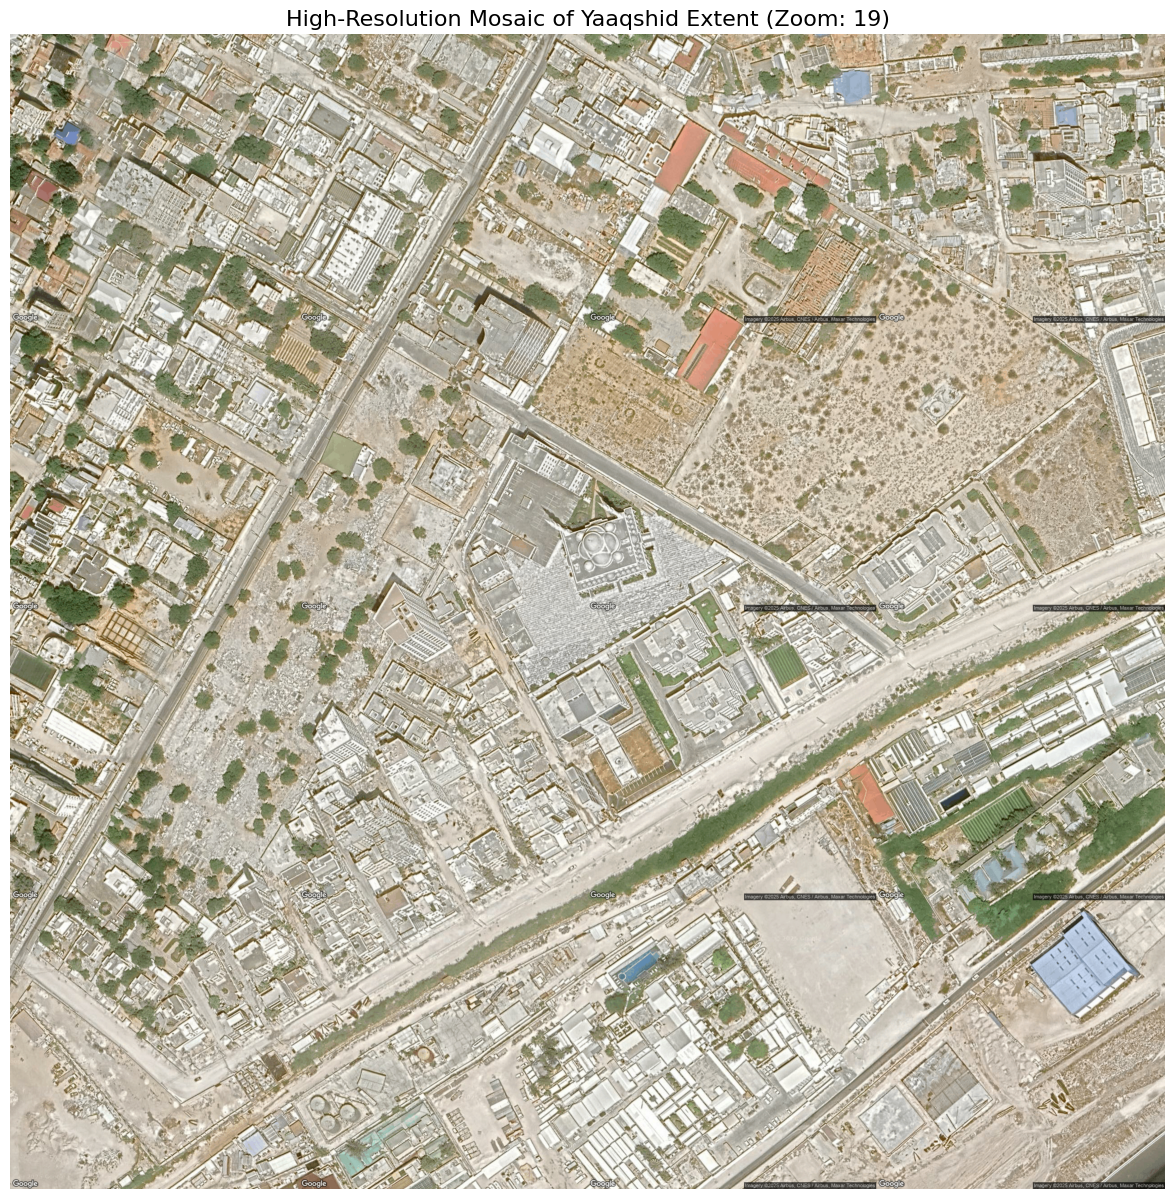


Image saved to: /content/jimaacale_mosaic_zoom_19.png
You can find it in the file browser on the left sidebar.


In [20]:
# Cell 3: Stitch Tiles into a Mosaic and Display

if not any(tile_images):
    print("\n🛑 No images were downloaded. Cannot create a mosaic.")
else:
    print("\nStitching tiles into a single mosaic image...")

    # Create a new, blank image to paste the tiles onto
    total_width = num_cols * TILE_SIZE
    total_height = num_rows * TILE_SIZE
    mosaic_image = Image.new('RGB', (total_width, total_height))

    # Paste each tile into its correct position
    for i, img in enumerate(tile_images):
        if img:
            row = i // num_cols
            col = i % num_cols
            x_offset = col * TILE_SIZE
            y_offset = row * TILE_SIZE
            mosaic_image.paste(img, (x_offset, y_offset))
        else:
            # Optionally, you could draw a "failed" box here
            pass

    print("✅ Mosaic created successfully!")

    # Display the final stitched image
    # We use matplotlib to control the size of the output display
    plt.figure(figsize=(15, 15)) # Adjust figure size for better viewing
    plt.imshow(mosaic_image)
    plt.title(f"High-Resolution Mosaic of Yaaqshid Extent (Zoom: {ZOOM_LEVEL})", fontsize=16)
    plt.axis('off') # Hide the black axes and ticks
    plt.show()

    # Optional: Save the final image to your Colab environment
    try:
        save_path = f"/content/jimaacale_mosaic_zoom_{ZOOM_LEVEL}.png"
        mosaic_image.save(save_path)
        print(f"\nImage saved to: {save_path}")
        print("You can find it in the file browser on the left sidebar.")
    except Exception as e:
        print(f"\nCould not save the image. Error: {e}")